In [1]:
import numpy as np
from icecream import ic
import circle_fit as circle
from tracker_coordinate_transform import *


In [2]:
with open("circle_samples.txt", 'r') as file:
    circle_samples = eval(file.read())

#circle_samples

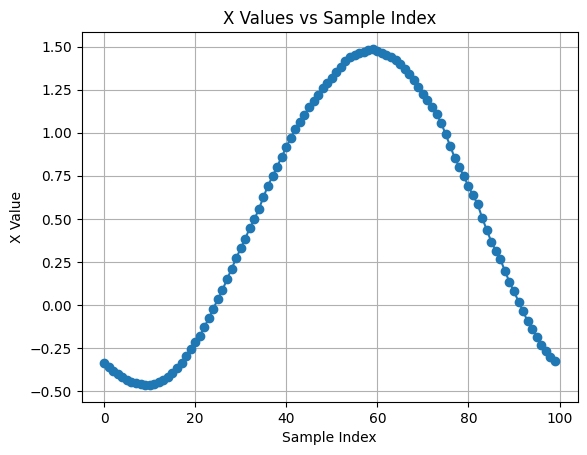

In [24]:
import matplotlib.pyplot as plt

# Extract x values
x_values_circle_samples = [point[0] for point in circle_samples]

# Plot
plt.plot(x_values_circle_samples, marker='o')
plt.title('X Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('X Value')
plt.grid(True)
plt.show()


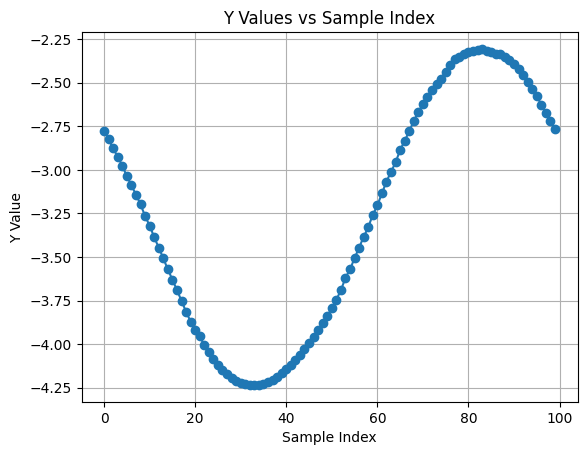

In [25]:
import matplotlib.pyplot as plt

# Extract x values
y_values_circle_samples = [point[1] for point in circle_samples]

# Plot
plt.plot(y_values_circle_samples, marker='o')
plt.title('Y Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Y Value')
plt.grid(True)
plt.show()


Calculated circle with error:  0.004633042834492194  xc:  0.5049212823888767  yc:  -3.269608150643713  r:  0.9693236646419723


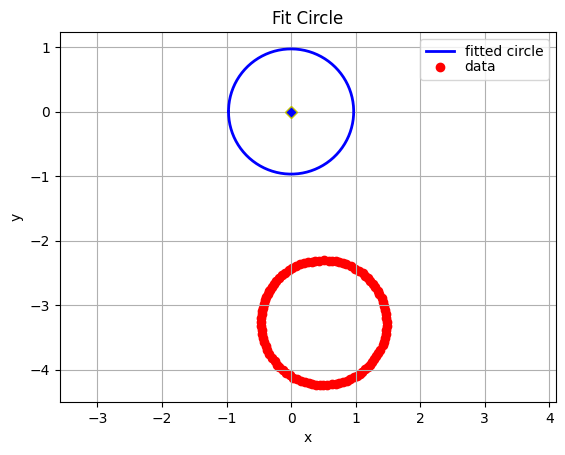

In [5]:
xc, yc, r, sigma = circle.standardLSQ(circle_samples)

print("Calculated circle with error: ", sigma, " xc: ", xc, " yc: ", yc, " r: ", r)
circle.plot_data_circle(circle_samples, 0, 0, r)


In [6]:
import numpy as np

def calculate_angle(point1, point2, center=(0, 0)):
    """
    Calculate the angle between two points on a circle with respect to the center.
    Result is in radians.
    """
    # Convert points to vectors from the center
    vector1 = np.subtract(point1, center)
    vector2 = np.subtract(point2, center)

    # Calculate the angle with atan2
    angle1 = np.arctan2(vector1[1], vector1[0])
    angle2 = np.arctan2(vector2[1], vector2[0])

    # Calculate the difference
    angle = angle2 - angle1

    # Normalize the result to be between -pi and pi
    angle = (angle + np.pi) % (2 * np.pi) - np.pi

    return angle

# Example points (x, y)
# point1 = (3, 4)
# point2 = (5, 1)
# center = (0, 0)  # Default center at (0, 0)

# angle = calculate_angle(point1, point2, center)
# print(f"Angle between points: {np.degrees(angle)} degrees")


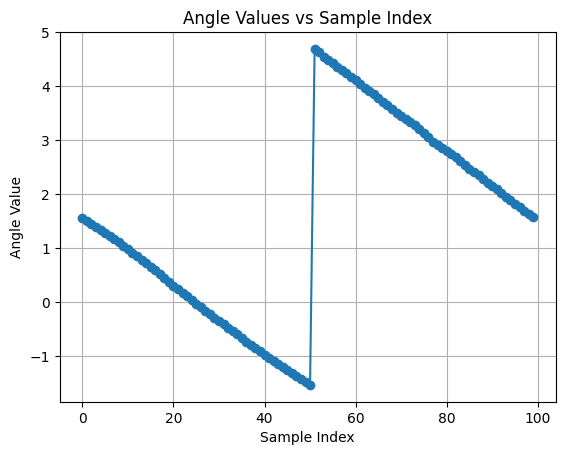

In [7]:
# Plot angle from starting point for each sample in the FRC coordinate system
# Extract angle values
angle_values = [calculate_angle(point,circle_samples[0], (xc,yc)) for point in circle_samples]
initial_angle = np.pi/2
angle_values = [(x + initial_angle) for x in angle_values]

# Plot
plt.plot(angle_values, marker='o')
plt.title('Angle Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Angle Value')
plt.grid(True)
plt.show()

In [8]:
# Calculate the (x,y) points for the calibration circle in the FRC coordinates, using the known starting point (0,r),
# known center point (0,0), the radius r, and the angle values from VR sampled data points.
FRC_circle_samples = [(r*np.cos(angle),r*np.sin(angle)) for angle in angle_values]


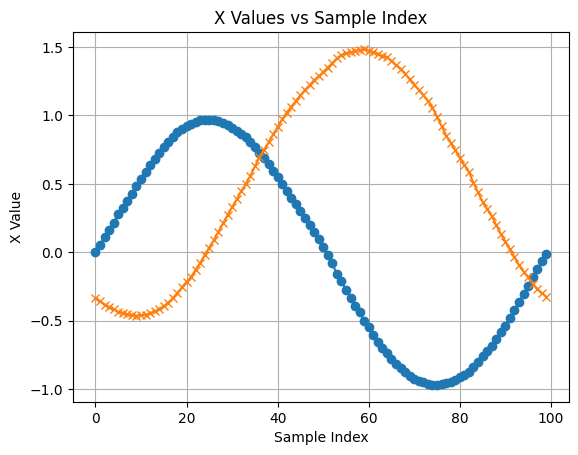

In [33]:
# Extract x values
x_values_FRC_circle_samples = [point[0] for point in FRC_circle_samples]

# Plot
plt.plot(x_values_FRC_circle_samples, marker='o')
plt.plot(x_values_circle_samples, marker='x')
plt.title('X Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('X Value')
plt.grid(True)
plt.show()

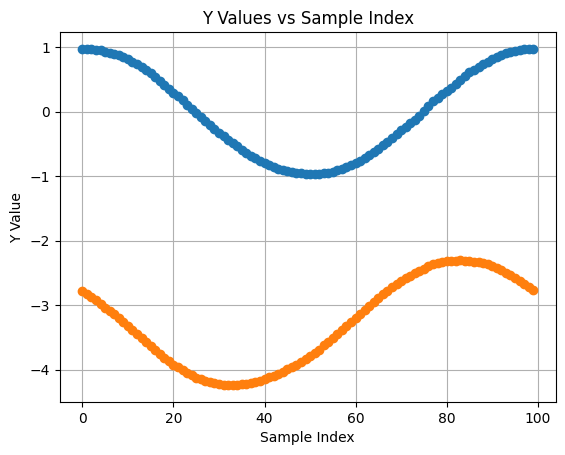

In [34]:
# Extract x values
y_values_FRC_circle_samples = [point[1] for point in FRC_circle_samples]

# Plot
plt.plot(y_values_FRC_circle_samples, marker='o')
plt.plot(y_values_circle_samples, marker='o')
plt.title('Y Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Y Value')
plt.grid(True)
plt.show()

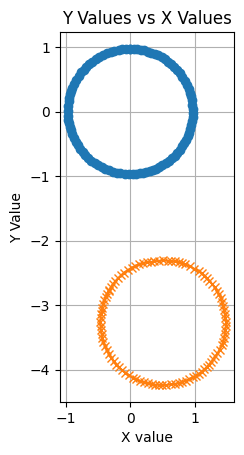

In [86]:
# Plot
# Create the plot
fig, ax = plt.subplots()


# Set aspect to be square
ax.set_aspect('equal') 
ax.plot(x_values_FRC_circle_samples, y_values_FRC_circle_samples, marker='o')
ax.plot(x_values_circle_samples, y_values_circle_samples, marker='x')
plt.title('Y Values vs X Values')
plt.xlabel('X value')
plt.ylabel('Y Value')
# Set aspect to be square
plt.grid(True)
plt.show()

In [11]:
fixingPoint = circle_samples[0]
ic(fixingPoint)
src_points = np.array([(xc, yc-r),(xc - r, yc),(xc, yc), (xc + r, yc), fixingPoint])
dst_points = np.array([(0, -r), (-r, 0), (0,0), (r, 0), (0, r)])

ic| fixingPoint: (-0.33586010336875916, -2.7751126289367676)


In [12]:
import numpy as np

def calculate_rotation_angle(coords1, coords2):
    """
    Calculate the rotation angle between two sets of coordinates on circles.

    Args:
        coords1 (list of tuples): Coordinates on the first circle.
        coords2 (list of tuples): Corresponding coordinates on the second circle.

    Returns:
        float: Rotation angle in degrees.
    """
    # Convert lists of tuples to numpy arrays
    coords1 = np.array(coords1)
    coords2 = np.array(coords2)

    # Calculate the center of each set of coordinates (assuming they are centered)
    center1 = np.mean(coords1, axis=0)
    center2 = np.mean(coords2, axis=0)

    # Translate coordinates to the origin
    translated_coords1 = coords1 - center1
    translated_coords2 = coords2 - center2

    # Calculate the rotation matrix using Singular Value Decomposition (SVD)
    U, _, Vt = np.linalg.svd(np.dot(translated_coords2.T, translated_coords1))
    R = np.dot(U, Vt)

    # Calculate the rotation angle in radians
    rotation_angle_rad = np.arctan2(R[1, 0], R[0, 0])

    # Convert rotation angle to degrees
    rotation_angle_deg = np.degrees(rotation_angle_rad)

    return rotation_angle_deg

# Example usage
# coords1 = [(1, 0), (0, 1), (-1, 0), (0, -1)]
# coords2 = [(0, -1), (1, 0), (0, 1), (-1, 0)]

# rotation_angle = calculate_rotation_angle(coords1, coords2)
# print(f"The rotation angle is {rotation_angle:.2f} degrees.")



In [13]:
rotation_angle = calculate_rotation_angle(src_points, dst_points)
ic(rotation_angle)  

ic| rotation_angle: np.float64(-13.880259721776829)


np.float64(-13.880259721776829)

ic| transformed_points: [(np.float64(-0.8407813857576358), np.float64(0.49449552170694533)),
                         (np.float64(-0.8638282667181003), np.float64(0.445544611138708)),
                         (np.float64(-0.8871328781625736), np.float64(0.39229286782205763)),
                         (np.float64(-0.9051416765233982), np.float64(0.3445609914487666)),
                         (np.float64(-0.9223197947523105), np.float64(0.29454887978494826)),
                         (np.float64(-0.939792181112479), np.float64(0.23190773598612013)),
                         (np.float64(-0.9503888736745822), np.float64(0.18155516259134474)),
                         (np.float64(-0.9593660484334934), np.float64(0.1267558442777461)),
                         (np.float64(-0.9650632391950595), np.float64(0.0726157533353633)),
                         (np.float64(-0.9682052384397495), np.float64(0.004037510079748063)),
                         (np.float64(-0.9662434111616123), np.float64(-0.05

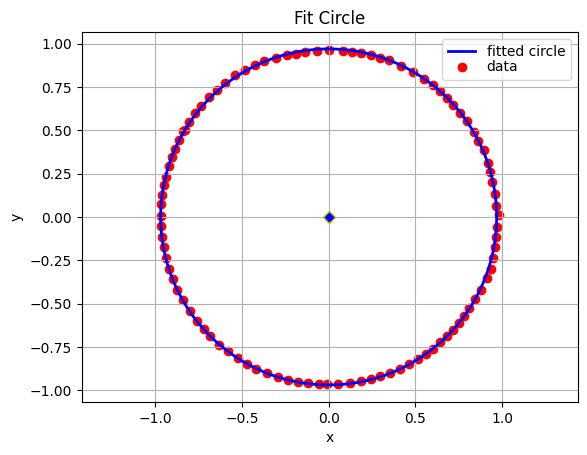

In [14]:
xOffset = 0
yOffset = 0
translation = (0 + xOffset - xc, 0 + yOffset - yc)
scale = (1,1)
    
  
transformed_points = [transform_point((x,y), translation, scale, 0) for x,y in circle_samples]
ic(transformed_points)
circle.plot_data_circle(transformed_points, 0, 0, r)

In [15]:
import numpy as np

def find_transformation_params(points1, points2):
    """
    Calculate the rotation matrix, scale factor, and translation vector
    from points in system 1 to system 2.
    """
    # Convert points to numpy arrays
    points1 = np.array(points1)
    points2 = np.array(points2)

    # Find the centroids of the points
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)

    # Center the points around the origin
    centered_points1 = points1 - centroid1
    centered_points2 = points2 - centroid2

    # Compute the covariance matrix
    H = np.dot(centered_points1.T, centered_points2)

    # Compute the singular value decomposition
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Ensure that the rotation matrix is a proper rotation
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Compute the scale factor
    var1 = np.var(centered_points1)
    var2 = np.var(centered_points2)
    s = np.sqrt(var2 / var1)

    # Compute the translation vector
    t = centroid2 - s * np.dot(R, centroid1)

    return R, s, t

# Sample data
# points1 = [(x1, y1), (x2, y2), ...]  # Replace with your points in system 1
# points2 = [(x1', y1'), (x2', y2'), ...]  # Replace with your corresponding points in system 2

# R, s, t = find_transformation_params(points1, points2)
# print(f"Rotation matrix: {R}")
# print(f"Scale factor: {s}")
# print(f"Translation vector: {t}")


In [16]:
def transform_coordinates(point, R, s, t):
    """
    Transform coordinates from system 1 to system 2 using the calculated
    rotation matrix, scale factor, and translation vector.
    """
    point = np.array(point)
    transformed_point = s * np.dot(R, point) + t
    return transformed_point

# Arbitrary coordinate in system 1
# arbitrary_point = (x, y)  # Replace with your point

# transformed_point = transform_coordinates(arbitrary_point, R, s, t)
# print(f"Transformed coordinates: {transformed_point}")


In [89]:
R, s, t = find_transformation_params(circle_samples, FRC_circle_samples)
print(f"Rotation matrix: {R}")
print(f"Scale factor: {s}")
print(f"Translation vector: {t}")

Rotation matrix: [[ 0.72895303  0.68456371]
 [-0.68456371  0.72895303]]
Scale factor: 0.9999885772845365
Translation vector: [1.88006772 2.73043118]


In [159]:
# Try with subset of the calibration points
# sample every 5th point and then use only the first 4 points
circle_samples_subset = [point for i, point in enumerate(circle_samples) if (i + 1) % 10 == 0][:10]
len(circle_samples_subset)
FRC_circle_samples_subset = [point for i, point in enumerate(FRC_circle_samples) if (i + 1) % 10 == 0][:10]
len(FRC_circle_samples_subset)


10

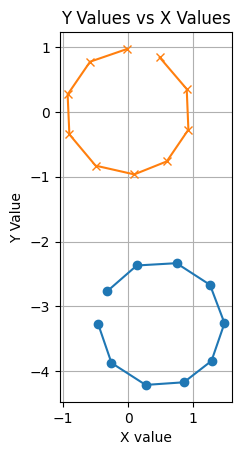

In [160]:
# Plot
# Create the plot
fig, ax = plt.subplots()
# Extract x,y values
x_values_circle_samples_subset = [point[0] for point in circle_samples_subset]
y_values_circle_samples_subset = [point[1] for point in circle_samples_subset]

x_values_FRC_circle_samples_subset = [point[0] for point in FRC_circle_samples_subset]
y_values_FRC_circle_samples_subset = [point[1] for point in FRC_circle_samples_subset]


# Set aspect to be square
ax.set_aspect('equal') 
ax.plot(x_values_circle_samples_subset, y_values_circle_samples_subset, marker='o')
ax.plot(x_values_FRC_circle_samples_subset, y_values_FRC_circle_samples_subset, marker='x')
plt.title('Y Values vs X Values')
plt.xlabel('X value')
plt.ylabel('Y Value')
# Set aspect to be square
plt.grid(True)
plt.show()

In [161]:
R, s, t = find_transformation_params(circle_samples_subset, FRC_circle_samples_subset)
print(f"Rotation matrix: {R}")
print(f"Scale factor: {s}")
print(f"Translation vector: {t}")

Rotation matrix: [[ 0.79335161  0.60876369]
 [-0.60876369  0.79335161]]
Scale factor: 0.9993497563511139
Translation vector: [1.60327339 2.90226132]


In [162]:
# transform the original set of VR sample points using the derived transformation constants. 
# These should match the "generated" FRC_circle_samples
FRC_circle_samples_verify = [transform_coordinates(point,R, s, t) for point in circle_samples]
#FRC_circle_samples_verify = [transform_coordinates(point,np.eye(2), 1.0, np.zeros(2)) for point in circle_samples] # no change configuration
print(f"Initial point (should be (0,{r})): {FRC_circle_samples_verify[0]}")

Initial point (should be (0,0.9693236646419723)): [-0.35129779  0.90637935]


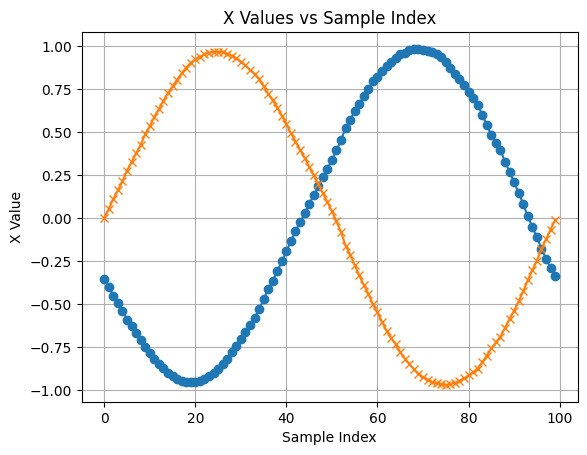

In [163]:
# Extract x values
x_values_FRC_circle_samples_verify = [point[0] for point in FRC_circle_samples_verify]

# Plot
plt.plot(x_values_FRC_circle_samples_verify, marker='o')
plt.plot(x_values_FRC_circle_samples, marker='x')
plt.title('X Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('X Value')
plt.grid(True)
plt.show()

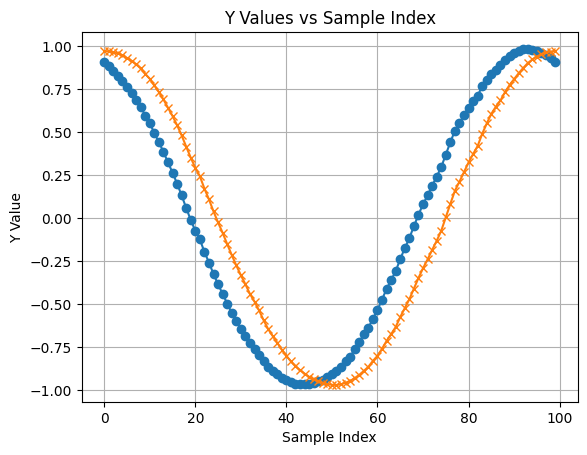

In [164]:
# Extract x values
y_values_FRC_circle_samples_verify = [point[1] for point in FRC_circle_samples_verify]

# Plot
plt.plot(y_values_FRC_circle_samples_verify, marker='o')
plt.plot(y_values_FRC_circle_samples, marker='x')
plt.title('Y Values vs Sample Index')
plt.xlabel('Sample Index')
plt.ylabel('Y Value')
plt.grid(True)
plt.show()

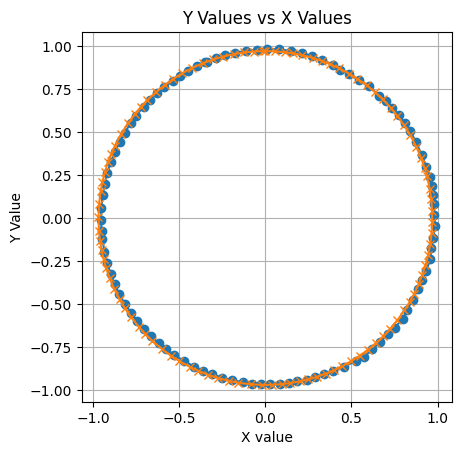

In [165]:
# Plot
# Create the plot
fig, ax = plt.subplots()


# Set aspect to be square
ax.set_aspect('equal') 
ax.plot(x_values_FRC_circle_samples_verify, y_values_FRC_circle_samples_verify, marker='o')
ax.plot(x_values_FRC_circle_samples, y_values_FRC_circle_samples, marker='x')
plt.title('Y Values vs X Values')
plt.xlabel('X value')
plt.ylabel('Y Value')
# Set aspect to be square
plt.grid(True)
plt.show()

In [166]:
rotation_angle = calculate_rotation_angle(FRC_circle_samples, FRC_circle_samples_verify)
ic(rotation_angle)  

circle_samples_zeroed = [(x-xc,y-yc) for x,y in circle_samples]

rotation_angle = calculate_rotation_angle(circle_samples_zeroed, FRC_circle_samples)
ic(rotation_angle)  

ic| rotation_angle: np.float64(-157.96156847582148)
ic| rotation_angle: np.float64(-120.46140522253677)


np.float64(-120.46140522253677)